# Machine Learning Classifier
Assign scores to predict the potential improvement in safety by installing smoke detectors in that area

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.set_option('display.max_columns',500)
sns.set()

In [2]:
nfirs = pd.read_csv('../data/02_interim/03_nfirs_geoids.csv',dtype={'geoid':str})

C:\Users\thwhi\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (2,3,6,16,18,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1. Read in data
2. Look at the descriptive statistics of the label (in this case smoke alarm presence)
2. Data cleaning
3. feature engineering
4. initial classifier (logistic regression)

How to determine if a given geographic area is less likely to have fire alarms? You can look at the number of fires, and the fraction of those fires which have smoke alarms in them. Seems easy enough.

The big problem is that it seems that the fire alarm data isn't always filled in. Either it's unknown for a lot of fires, or perhaps some fire departments just don't fill it in.

In [3]:
nfirs.head()

,rcp2_id,state,fdid,inc_no,city,street,zip5,inc_date,oth_inj,oth_death,exp_no,inc_type,prop_loss,cont_loss,tot_loss,detector,det_type,det_power,det_operat,det_effect,det_fail,aes_pres,aes_type,aes_oper,no_spr_op,aes_fail,geoid,match,match_type,tiger_line_id,tiger_line_side,lon,lat
0,rcp2_id1,AK,11100,211,JUNEAU,1700 ANGUS WAY,99801,2009-01-03,0.0,0.0,0.0,111,20000.0,5000.0,25000.0,1,1,1,2,1,NaN,N,NaN,NaN,NaN,NaN,02110000500,Match,Exact,190964136.0,R,-134.42440,58.306507
1,rcp2_id2,AK,11100,470,JUNEAU,3221 PIONEER AVE,99801,2009-01-06,0.0,0.0,0.0,114,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,02110000600,Match,Exact,190966361.0,R,-134.43314,58.292686
2,rcp2_id3,AK,11100,556,JUNEAU,10231 HERON WAY,99801,2009-01-06,0.0,0.0,0.0,111,20000.0,5000.0,25000.0,N,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,02110000100,Match,Exact,190962538.0,R,-134.60330,58.402610
3,rcp2_id4,AK,11100,1315,JUNEAU,6590 GLACIER HWY,99801,2009-01-13,0.0,0.0,0.0,113,200.0,20.0,220.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,02110000400,Match,Exact,190963741.0,R,-134.51932,58.358955
4,rcp2_id5,AK,11100,2151,JUNEAU,6590 GLACIER HWY,99801,2009-01-21,0.0,0.0,0.0,111,35000.0,5000.0,40000.0,N,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,02110000400,Match,Exact,190963741.0,R,-134.51932,58.358955


In [4]:
nfirs['detector'].value_counts(dropna=False)

NaN    925886
1      466610
U      301345
N      265265
Name: detector, dtype: int64

About 50% of the entries are NaN, and then another 15% are listed as U. So it's unknown whether there's a fire alarm in about 65% of the homes where there are fires.

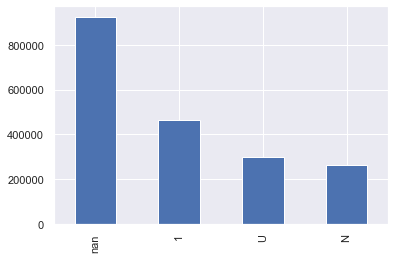

In [5]:
nfirs['detector'].value_counts(dropna=False).plot.bar()

In [6]:
# So, I want to aggregate the smoke detector statistics by geoid

geoids = pd.crosstab(nfirs['geoid'],nfirs['detector'].fillna('nan'))

In [7]:
geoids['ratio'] = geoids['1'] / (geoids['1'] + geoids['N']) 

In [8]:
cols_to_add = ['geoid','city','state','fdid']
geoids = (geoids.reset_index()
          .merge(nfirs[cols_to_add].drop_duplicates(subset='geoid'),
                 how='left',left_on='geoid',right_on='geoid')
          .set_index('geoid')
          .sort_index())

In [9]:
geoids.sort_values(['ratio','1'],ascending=False).head()

,1,N,U,nan,ratio,city,state,fdid
geoid,,,,,,,,
25025160101,149,0,41,46,1.0,CHELSEA,MA,25057
25025160601,109,0,31,27,1.0,CHELSEA,MA,25057
25025160300,69,0,5,13,1.0,CHELSEA,MA,25057
36083051600,65,0,2,7,1.0,RENSSELAER,NY,42029
55133201402,65,0,1,20,1.0,NEW BERLIN,WI,67010


In [10]:
geoids.sort_values(['ratio','N'],ascending=False).head()

,1,N,U,nan,ratio,city,state,fdid
geoid,,,,,,,,
01001020500,16,0,6,39,1.0,Prattville,AL,401
01001020801,4,0,1,3,1.0,Prattville,AL,401
01001020802,3,0,0,5,1.0,Prattville,AL,401
01003010400,1,0,4,4,1.0,Bay Minette,AL,501
01003010903,3,0,7,3,1.0,Loxley,AL,00507


So, it appears that some areas have almost no locations where fires occur with a smoke detector, while in other locations almost every location with a fire has a smoke detector.

For now, I won't worry too much about the possible data provenance and quality issues, and just create a classifier using the available data to see what it looks like.

One way to do that though would be to groupby fire department id to see if specific fire departments tend to mark a surprising number of fires as being in areas without a smoke detector. Though it'll always be difficult to determine if it's just an area that doesn't have many smoke detectors or if it's that a given fire department is less diligent about checking whether there's a smoke detector.

In [11]:
fdids = pd.crosstab(nfirs['fdid'],nfirs['detector'].fillna('nan'))

In [12]:
fdids['tot_fires'] = fdids[['1','N','U','nan']].sum(axis=1)

In [13]:
fdids['ratio'] = fdids['1'] / (fdids['1'] + fdids['N']) 
cols_to_add = ['fdid','city','state']
fdids = (fdids.reset_index()
          .merge(nfirs[cols_to_add].drop_duplicates(subset='fdid'),
                 how='left',left_on='fdid',right_on='fdid'))

In [14]:
fdids = fdids.set_index('fdid')

In [15]:
fdids[fdids['tot_fires']>50].sort_values('ratio').head()

,1,N,U,nan,tot_fires,ratio,city,state
fdid,,,,,,,,
08052,0,36,0,42,78,0.00000,CHANDLER,AZ
VC304,0,2,60,3,65,0.00000,POINT BLANK,TX
52062,0,1,2,52,55,0.00000,Manorville,NY
78000,0,8,95,72,175,0.00000,South Boston,VA
08207,111,12663,5,1203,13982,0.00869,NEWTON GROVE,NC


In [16]:
nfirs[nfirs['fdid']=='08207']['city'].unique()

array(['NEWTON GROVE', 'Detroit', 'DETROIT', 'detroit', 'DET',
       'Wayne State Universi', 'deroit', 'Harper Woods', 'Frankford',
       'DETRIOIT', '307', 'Detroti', 'DETROITMI', 'DetroitMI',
       'Detroitmi'], dtype=object)